## Generate Thei-sen slope for tornado reports
##### Dr. Victor Gensini (Spring 2018)
##### Department of Geographic and Atmospheric Sciences
<img style="float:left;height:40px"src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQthtdrc2lZyEOC1iiwubFyvNfzJE7q7_GCTdlFF3peKckmi7cN">

In [1]:
from netCDF4 import date2num,date2index
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy import ndimage
import scipy.stats
import matplotlib.font_manager as font_manager
from matplotlib import cm
from matplotlib.path import Path
import matplotlib.colors as colors
from matplotlib.mlab import bivariate_normal
from matplotlib.colors import LogNorm
from mpl_toolkits.basemap import Basemap, maskoceans
from scipy.stats.mstats import linregress
from scipy import stats
import shapefile
import datetime
#import seaborn as sns
#sns.set()

(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)
(38, 100, 300)
(100,)


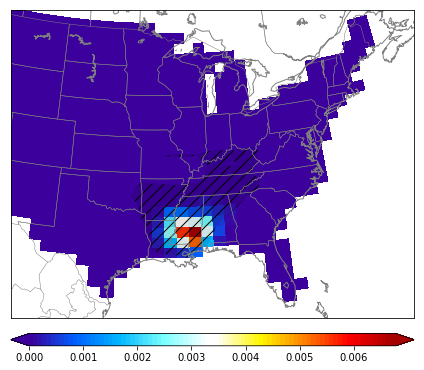

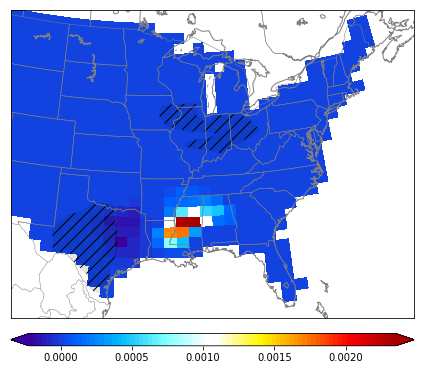

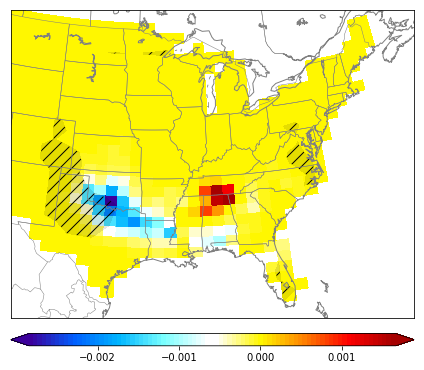

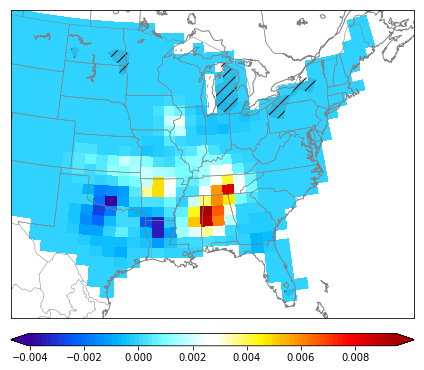

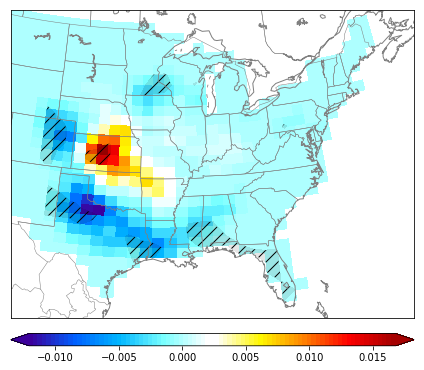

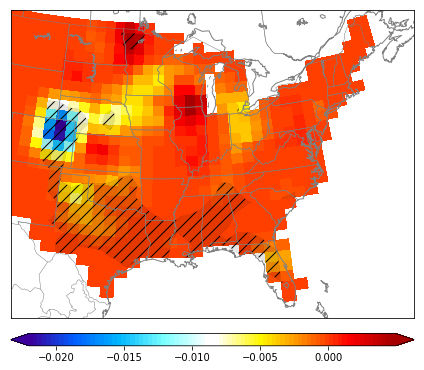

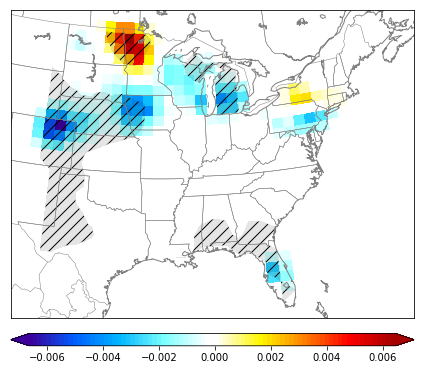

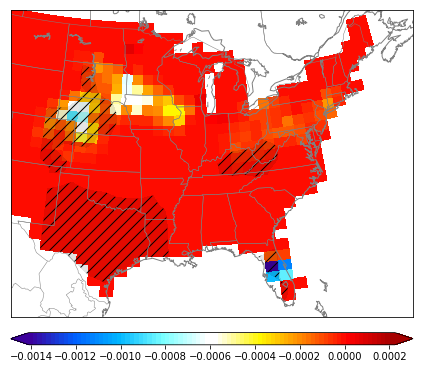

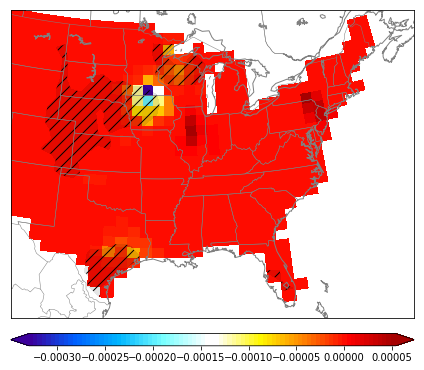

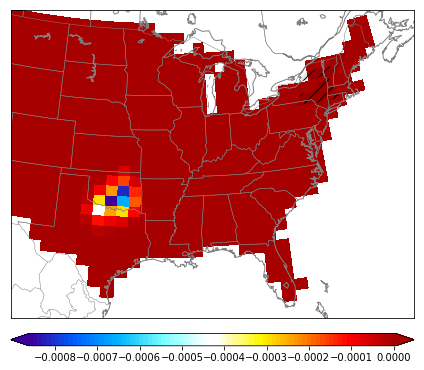

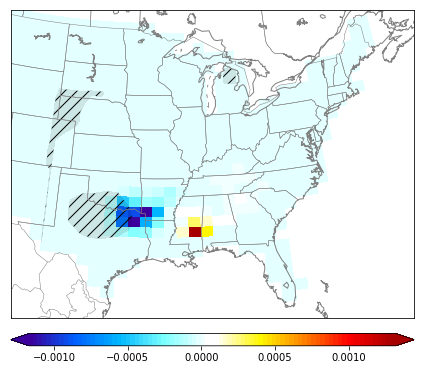

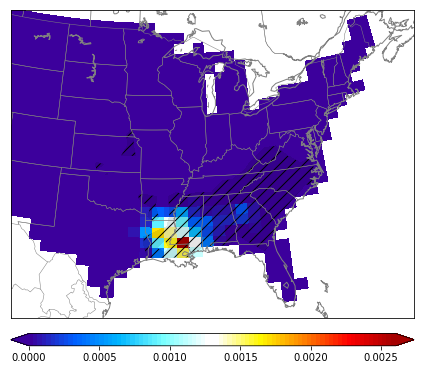

In [2]:
datadir = '/home/data/stp_narr/'
nc1 = Dataset('narr_latlon.nc','r',format='NETCDF4_CLASSIC')
lats = nc1.variables["lats"][0][:][:]
lons = nc1.variables["lons"][0][:][:]
nc1.close()
#####################################################
#Nx * Ny
nx, ny = 350,150
#####################################################
density_yr = np.empty((0,150,350))

nx, ny = 300,100
#####################################################
density_yr = np.empty((0,100,300))

tor_file = '1950-2016_tor.csv'
tor_df = pd.read_csv(tor_file)
formats = '%Y-%m-%d'
tor_df['datei']=pd.to_datetime(tor_df['date'], format=formats)
tor_df=tor_df.set_index(pd.DatetimeIndex(tor_df['datei']))
years = np.arange(1979,2017,1)
months = np.arange(1,13,1)
for mn in months:
    for yr in years:
        query='yr==%s & mag>=1 & mo==%s' % (yr,mn)
        torday_df = tor_df.query(query)
        tor_lons=torday_df['slon']
        tor_lats=torday_df['slat']

        ####################################################
        # compute appropriate bins to histogram the data into
        lon_bins = np.linspace(lons.min(), lons.max(), nx+1)
        lat_bins = np.linspace(lats.min(), lats.max(), ny+1)
        lon_bins1 = np.linspace(lons.min(), lons.max(), nx)
        lat_bins1 = np.linspace(lats.min(), lats.max(), ny)
        # Histogram the lats and lons to produce an array of frequencies in each box.
        # Because histogram2d does not follow the cartesian convention 
        # (as documented in the numpy.histogram2d docs) we need to provide lats and lons rather than lons and lats
        density, _, _ = np.histogram2d(tor_lats, tor_lons, [lat_bins, lon_bins])
        #print(density)
        #print(density.shape)
        # Turn the lon/lat bins into 2 dimensional arrays ready for conversion into projected coordinates
        lon_bins_2d, lat_bins_2d = np.meshgrid(lon_bins, lat_bins) # BINS FOR FIGURE
        lon_bins_2d1, lat_bins_2d1 = np.meshgrid(lon_bins1, lat_bins1) # BINS FOR netCDF
        sigma = 1
        mean_ph1 = scipy.ndimage.filters.gaussian_filter(density,sigma,order=0)
        density_yr=np.append(density_yr,[mean_ph1],axis=0)
    print (density_yr.shape)
    print(lat_bins1.shape)
    def theilsen(a,years):
        yr,y,x = a.shape
        slope = np.zeros((y,x))   
        intercept = np.zeros((y,x))   
        lo = np.zeros((y,x))
        up = np.zeros((y,x))   
        for yy in range(y):
            for xx in range(x):
                slope[yy,xx],intercept[yy,xx],lo[yy,xx],up[yy,xx] = stats.mstats.theilslopes(a[:,yy,xx],years)
        return slope

    def kendalltau(a,years):
        yr,y,x = a.shape   
        tau = np.zeros((y,x))   
        pval = np.zeros((y,x))   
        for yy in range(y):
            for xx in range(x):
                tau[yy,xx],pval[yy,xx] = stats.kendalltau(years,a[:,yy,xx])#,years)
        #return (tau,pval)
        return pval

    slope = theilsen(density_yr,years)
    pval = kendalltau(density_yr,years)

    #print (pval.shape)

    #read shapefile using pyshp (http://code.google.com/p/pyshp/)
    sf = shapefile.Reader('/home/vgensini/projects/stp/shapefiles/US_outline.shp')
    sfrec = sf.shapeRecord()
    points = sfrec.shape.points
    #print points
    latty_bin = lat_bins_2d1.flatten()
    lonny_bin = lon_bins_2d1.flatten()
    lonlat = []

    for lt,ln in zip(latty_bin,lonny_bin):
        lonlat.append([ln,lt])
    #use points_inside_polygon to 
    #clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
    path = Path(points)
    clip = path.contains_points(lonlat)

    #reshape array
    clip = clip.reshape(density.shape)

    #read shapefile using pyshp (http://code.google.com/p/pyshp/)
    sf = shapefile.Reader('/home/vgensini/projects/stp/shapefiles/mask.shp')
    sfrec = sf.shapeRecord()
    points = sfrec.shape.points
    #print points
    latty_bin = lat_bins_2d1.flatten()
    lonny_bin = lon_bins_2d1.flatten()
    lonlat = []

    for lt,ln in zip(latty_bin,lonny_bin):
        lonlat.append([ln,lt])
    #use points_inside_polygon to 
    #clip = matplotlib.nxutils.points_inside_poly(lonlat,points)
    path = Path(points)
    clip1 = path.contains_points(lonlat)

    #reshape array
    clip1 = clip1.reshape(density.shape)

    #print (vals.shape)
    fig = plt.figure()
    fig.set_size_inches(6,6)
    m = Basemap  (projection='lcc',lon_0=-92.54199,lat_0=38.09401,llcrnrlat=24, urcrnrlat=47,llcrnrlon=-106,urcrnrlon=-61,resolution='l',area_thresh=1000)
    m.drawcoastlines(color='gray')
    m.drawstates(color='gray')
    #masked = maskoceans(lon_bins_2d1,lat_bins_2d1,slope)
    masked = np.ma.masked_where(clip==False,slope)
    #masked1 = maskoceans(lon_bins_2d1,lat_bins_2d1,pval)
    masked1 = np.ma.masked_where(clip1==False,pval)
    m.drawcountries(color='gray')
    x,y = m(lons,lats)
    temper_anom = ['#3c009c','#3609A5','#3013AF','#2A1CB9','#2426C3','#1E30CD','#1839D7','#1243E1','#0C4CEB','#0656F5','#0060FF','#0068FF','#0071FF','#0079FF','#0082FF','#008BFF','#0093FF','#009CFF','#00A4FF','#00ADFF','#00B6FF','#0CBDFF','#18C4FF','#24CBFF','#30D3FF','#3CDAFF','#48E1FF','#54E9FF','#60F0FF','#6CF7FF','#79FFFF','#86FFFF','#93FFFF','#A1FFFF','#AEFFFF','#BCFFFF','#C9FFFF','#D6FFFF','#E4FFFF','#F1FFFF','#FFFFFF','#FFFFFF','#FFFFFF','#FFFEE5','#FFFDCC','#FFFCB2','#FFFB99','#FFFB7F','#FFFA66','#FFF94C','#FFF833','#FFF719','#FFF700','#FFEB00','#FFDF00','#FFD300','#FFC700','#FFBB00','#FFAF00','#FFA300','#FF9700','#FF8B00','#FF7F00','#FE7200','#FE6500','#FE5800','#FE4C00','#FE3F00','#FE3200','#FE2600','#FE1900','#FE0C00','#FE0000','#F50000','#EC0000','#E30000','#DA0000','#D20000','#C90000','#C00000','#B70000','#AE0000','#A60000']
    cmap = matplotlib.colors.ListedColormap(temper_anom)
    xs, ys = m(lon_bins_2d1, lat_bins_2d1)
    m_max = np.ndarray.max(masked)
    m_min = np.ndarray.min(masked)
    plot = m.pcolormesh(xs,ys,masked,zorder=1,vmin=m_min, vmax=m_max,cmap=cmap)
    colbar = m.colorbar(plot,"bottom", size="4%",pad="5%",extend='both')
    #colbar.set_label('1979-2016 Theil-Sen Slope of Annual Tornado Reports',fontsize='medium',weight='bold')
    levs = [-0.05,0.05]
    #m.contour(xs,ys,masked1,levs,colors='black')
    m.contourf(xs,ys,masked1,levs,cmap=None,colors='black',alpha=.1,hatches=['//'])
    #levs1 = [-900,-1.96]
    #m.contourf(x,y,sigdiff,levs1,color=None,hatch=['/'])
    plt.tight_layout()
    plt.savefig('Figure5_'+str(mn)+'.png',dpi=100)
    density_yr = np.empty((0,100,300))

    